In [1]:
import random
import scipy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import minimize
from user_distributions import oneFarOneClose, leftSkewedNormal, leftUpSkewedNormal, leftUpRectangles, normalDistribution

# Seed random number generators
seed = 324
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed)

## Parameters
Constant parameters used for the simulation

In [10]:
r_min = 500 # meters
r_max = 15000 # meters
D = 15000 # meters
rD = 2000 # meters
cx_min = -20000 # meters
cx_max = 40000 # meters
cy_min = -20000
cy_max = 20000
v = 50 # meters/second

N = 200 # timeslots in one rotation
M = 2 # users
K = 20 # total number of users

# therefore, each user should get scheduled 40 times

H = 1000 # meters
PAtx = 10 # watts
PUtx = 0.01 # watts
GT = 1
GR = 1
B = 1e6 # Hz
N0 = 10**((7.5-174+10*np.log10(B))/10)/1000 # watts
F = 2e9 # Hz
WAVELENGTH = scipy.constants.c / F # meters

## Constants for convenience
- `thetas` = UAV angle at each timeslot
- `cos_th` = $\cos(\text{UAV angle at each timeslot})$
- `sin_th` = $\sin(\text{UAV angle at each timeslot})$
- `CU` = $P^\text{U}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `CA` = $P^\text{A}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `AU` = $\frac{C_\text{U}M}{N_0}$
- `AB` = $\frac{C_\text{A}}{N_0}$ 

In [3]:
thetas = 2*np.pi*np.arange(N)/N
cos_th = np.cos(thetas)
sin_th = np.sin(thetas)
CU = PUtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
CA = PAtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
AU = (CU * M) / N0
AB = CA / N0

## User Generation
Here we define a function to randomly generate users within the deadzone. For the purposes of the simulation, we generate the maximum number of users. Smaller flight paths may not serve every user in one rotation, but the objective is normalized over timeslots. We plot the users at the end to verify that the distribution is correct.

len(users): 20
K: 20


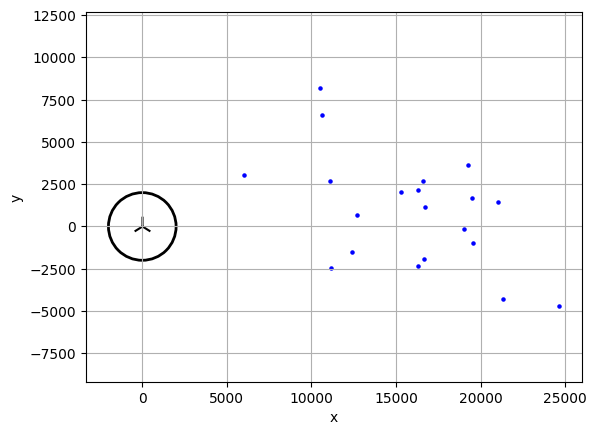

In [17]:
# users = leftUpRectangles(K, 5000, 1000, D, 0, seed=seed)
# users = leftUpSkewedNormal(K, D, 15000, D, 15000, seed)
users = normalDistribution(K, D, 0, 3000, seed=seed)
print(f'len(users): {len(users)}')
print(f'K: {K}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
ax = plt.gca()  # get current axes
circle = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=2)
ax.add_patch(circle)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()

## Mean SE (objective function)
The average achievable spectral efficiency of the relay system over the timeslots is given as
$$\overline{\text{SE}}(\alpha, r, \mathbf{c}, a) = \frac{1}{N}\sum_{n=1}^N \min\left[\frac{\alpha}{M}\sum_{k=1}^K a_{n,k}\cdot\text{SE}^\text{UA}_{n,k}\;\mathbf{,}\;(1-\alpha)\cdot\text{SE}^\text{AB}_n\right]$$

In [ ]:
def meanSE(alpha, 
           r, 
           cx, 
           cy, 
           a,
           users=users,
           AU=AU,
           AB=AB,
           H=H,
           M=M):

    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    dx = ax[:, None] - users[:, 0]
    dy = ay[:, None] - users[:, 1]
    snk0 = dx*dx + dy*dy + H*H

    sbn0 = (ax*ax + ay*ay + H*H)

    # Calculate SEUA
    log_terms = np.log2(1.0 + AU/snk0)
    seua = (alpha/M) * np.sum(a * log_terms, axis=1)

    # Calculate SEAB
    seab = (1-alpha) * np.log2(1.0 + AB/sbn0)

    # Calculate the mins
    min_se = np.minimum(seua, seab)

    # Return the average
    return np.mean(min_se)

## $\alpha$ Optimizer
Here I will define an optimizer to find the optimal $\alpha$ for a fixed $r$, $\mathbf{c}$.

In [ ]:
def optimize_alpha(r, 
                   cx, 
                   cy, 
                   a, 
                   users=users, 
                   AU=AU,
                   AB=AB,
                   H=H,
                   M=M,
                   verbose=False):
    
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    dx = ax[:, None] - users[:, 0]
    dy = ay[:, None] - users[:, 1]
    snk0 = dx*dx + dy*dy + H*H
    sbn0 = (ax*ax + ay*ay + H*H)

    # Vectorized computation of an and bn
    # an[n] = sum over users of a[n] * log2(1 + AU/snk0[n])
    log_terms = np.log2(1.0 + AU/snk0)  # Shape: (N, num_users)
    an = np.sum(a * log_terms, axis=1)   # Shape: (N,) - sum over users for each timeslot
    bn = np.log2(1.0 + AB/sbn0)          # Shape: (N,)

    alpha_var = cp.Variable()
    tn_var = cp.Variable(N)

    # Vectorized constraints
    cons = []
    cons += [tn_var <= (alpha_var/M) * an]      # Vectorized constraint
    cons += [tn_var <= (1 - alpha_var) * bn]    # Vectorized constraint
    cons += [alpha_var >= 0, alpha_var <= 1]

    obj = cp.Maximize( cp.mean(tn_var) )

    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.MOSEK, verbose=verbose)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError(f"SCA subproblem infeasible/failed: status {prob.status}")
    
    return float(alpha_var.value)

## $a$ Optimizer

In [ ]:
def optimize_a(alpha, 
               r, 
               cx, 
               cy, 
               users=users,
               AU=AU,
               AB=AB,
               H=H,
               M=M,
               verbose=False):
    
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    dx = ax[:, None] - users[:, 0]
    dy = ay[:, None] - users[:, 1]
    snk0 = dx*dx + dy*dy + H*H
    sbn0 = (ax*ax + ay*ay + H*H)

    # Calculate seua and seab
    seua = (alpha/M) * np.log2(1.0 + AU/snk0)  # Shape: (N, num_users)
    seab = (1-alpha) * np.log2(1.0 + AB/sbn0)   # Shape: (N,)

    # define CVXPY variables
    a_vars = cp.Variable((N, K))
    t_vars = cp.Variable(N)

    # Constraints
    cons = []

    # Add tn constraints - vectorized
    cons += [t_vars[n] <= cp.sum(cp.multiply(a_vars[n], seua[n])) for n in range(N)]
    cons += [t_vars <= seab]  # Vectorized constraint
    
    # Box constraints on a_vars - vectorized
    cons += [a_vars >= 0, a_vars <= 1]
    
     # Column sum constraint: each user at most once - vectorized
    cons += [cp.sum(a_vars, axis=0) <= (N*M)/K]
    
    # Row sum constraint: at most M users per timeslot - vectorized
    cons += [cp.sum(a_vars, axis=1) <= M]

    # Want to maximize tn
    obj = cp.Maximize( cp.mean(t_vars) )

    # Solve problem and check convergence
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.MOSEK, verbose=verbose)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError(f"SCA subproblem infeasible/failed: status {prob.status}")
    
    return a_vars.value

## Random scheduling
random scheduling function for testing

In [ ]:
def random_schedule(M=M, maxiters=1000, tol=1e-9):
    mat = np.random.rand(N, K)

    for _ in range(maxiters):
        # Scale rows
        row_sums = mat.sum(axis=1, keepdims=True)
        mat *= (M / row_sums)

        # Scale columns
        col_sums = mat.sum(axis=0, keepdims=True)
        mat *= ( (N*M/K) / col_sums)

        # Check convergence
        if (np.allclose(mat.sum(axis=1), M, atol=tol) and
            np.allclose(mat.sum(axis=0), N, atol=tol)):
            break

    return mat

## Powell's optimizer for $\alpha$, $r$, $\mathbf{c}$
Here I define a block optimizer to iteratively optimize $\alpha$, $r$, $\mathbf{c}$.

Powell's Optimizer Iteration 0
    Values at iteration 0: alpha = 0.5, r=7750.0, c=(10000.0, 0.0)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 1
    Values at iteration 1: alpha = 0.606257296241885, r=2921.721189018416, c=(13249.131063937386, 433.057483963449)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 2
    Values at iteration 2: alpha = 0.6064444178205319, r=3189.608508447845, c=(13963.361100059985, 729.7554778555966)
    User scheduling optimized
    Timeshare optimized
    Trajectory optimized, result.message: Optimization terminated successfully.

Powell's Optimizer Iteration 3
    Values at iteration 3: alpha = 0.6064444178205916, r=3128.5006108280754, c=(14239.242707579233, 809.6863400576146)
    User scheduling optimized
    Timeshare optimiz

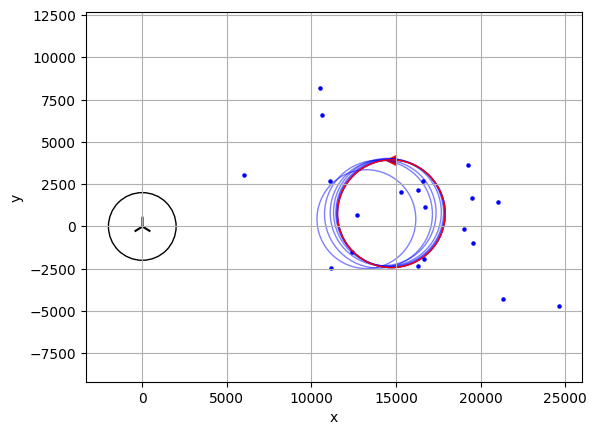

In [ ]:
def objective(params, alpha, a, users, AU, AB, H, M):
    r, cx, cy = params
    return -meanSE(alpha, 
                   r, 
                   cx, 
                   cy, 
                   a, 
                   users=users,
                   AU=AU,
                   AB=AB,
                   H=H,
                   M=M)

def powells_optimizer(
                    alpha0,
                    r0, 
                    cx0, 
                    cy0, 
                    rbounds=(r_min, r_max),
                    cxbounds=(cx_min, cx_max),
                    cybounds=(cy_min, cy_max),
                    users=users,
                    AU=AU,
                    AB=AB,
                    H=H,
                    M=M,
                    tolerance=1e-3,
                    verbose=True
):

    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0
    bounds = [rbounds, cxbounds, cybounds]

    traj_history = []
    obj_history = []

    it = 0
    while True:
        if verbose:
            print(f'Powell\'s Optimizer Iteration {it}')
            print(f'    Values at iteration {it}: alpha = {alpha}, r={r}, c=({cx}, {cy})')

        a = optimize_a(alpha, 
                       r, 
                       cx, 
                       cy, 
                       users=users,
                       AU=AU,
                       AB=AB,
                       H=H,
                       M=M)
        if verbose:
            print('    User scheduling optimized')

        alpha = optimize_alpha(r,
                               cx,
                               cy,
                               a,
                               users=users,
                               AU=AU,
                               AB=AB,
                               H=H,
                               M=M)
        if verbose:
            print('    Timeshare optimized')
        
        result = minimize(
                    objective,
                    [r,cx,cy],
                    args=(alpha, a, users, AU, AB, H, M),
                    method='Powell',
                    bounds=bounds,
                    options={
                        'maxiter':1000,
                        'xtol':1e-3,
                        'ftol':1e-3
                    }
        )
        if verbose:
            print(f'    Trajectory optimized, result.message: {result.message}')
            print()

        r, cx, cy = result.x

        obj_history.append(meanSE(alpha, 
                                  r, 
                                  cx, 
                                  cy, 
                                  a, 
                                  users=users,
                                  AU=AU,
                                  AB=AB,
                                  H=H,
                                  M=M))
        traj_history.append((r, cx, cy))

        if it > 0:
            if ( (obj_history[-1] - obj_history[-2])/obj_history[-2] < tolerance):
                break
        it += 1
    
    return alpha, a, traj_history
        
alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, a_opt, traj_hist = powells_optimizer(alpha0, r0, cx0, cy0)
r_opt, cx_opt, cy_opt = traj_hist[-1]

print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt, a_opt)}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)

for traj in traj_hist:
    r, cx, cy = traj
    path = patches.Circle((cx, cy), radius=r, fill=False, color='blue', alpha=0.5, linewidth=1)
    ax.add_patch(path)

ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()


## Successive convex approximation

SCA Optimizer Iteration 0
    MOSEK Iteration 0
    MOSEK Iteration 1
    MOSEK Iteration 2
    MOSEK Iteration 3
    MOSEK Iteration 4
    MOSEK Iteration 5
    MOSEK Iteration 6
    MOSEK Iteration 7
    MOSEK Iteration 8
    MOSEK Iteration 9
    MOSEK Iteration 10
    MOSEK Iteration 11
    MOSEK Iteration 12
SCA Iteration 0 results:
alpha = 0.606257296241885, radius = 3004.5736133038126, center = (13123.357592237986, 459.55717244097957)

SCA Optimizer Iteration 1
    MOSEK Iteration 0
    MOSEK Iteration 1
    MOSEK Iteration 2
SCA Iteration 1 results:
alpha = 0.6107082202131275, radius = 3171.2028340201055, center = (13785.82206118582, 710.3851933605852)

SCA Optimizer Iteration 2
    MOSEK Iteration 0
    MOSEK Iteration 1
    MOSEK Iteration 2
SCA Iteration 2 results:
alpha = 0.6107082202131747, radius = 3063.892583682273, center = (14027.116978661263, 805.0281891047574)

SCA Optimizer Iteration 3
    MOSEK Iteration 0
    MOSEK Iteration 1
SCA Iteration 3 results:
alpha = 0.61

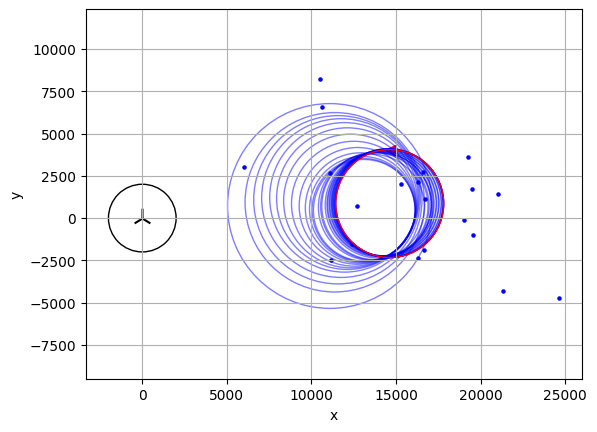

In [ ]:
def sca_optimizer(
                alpha0, 
                r0, 
                cx0, 
                cy0,
                r_bounds=(r_min, r_max), 
                cx_bounds=(cx_min, cx_max), 
                cy_bounds=(cy_min, cy_max),
                users=users,
                AU=AU,
                AB=AB,
                H=H,
                M=M,
                tol=2e-3,
                mosek_tol=1e-3,
                max_mosek_iters=30,
                verbose=False
):
    
    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0

    # Precompute constants
    users_x = users[:, 0]  # Shape: (K,)
    users_y = users[:, 1]  # Shape: (K,)
    H_squared = H * H
    scale_factor = 5e6
    grad_factor = scale_factor / np.log(2.0)

    def f_and_grad(s, A):
        """Return f(s)=log2(1+A/s) and f'(s) = -A/(ln2*s*(s+A)) elementwise."""
        s = np.maximum(s, 1e-9)
        f = scale_factor * np.log2(1.0 + A/s)
        fp = -grad_factor * A / (s * (s + A))
        return f, fp
    
    traj_hist = []
    obj_hist = []
    snk_error = []
    sbn_error = []

    it = 0
    while True:
        print(f'SCA Optimizer Iteration {it}')

        # schedule optimization
        a = optimize_a(alpha,
                       r,
                       cx,
                       cy,
                       users=users,
                       AU=AU,
                       AB=AB,
                       H=H,
                       M=M)

        # alpha optimization
        alpha = optimize_alpha(r,
                               cx,
                               cy, 
                               a, 
                               users=users,
                               AU=AU,
                               AB=AB,
                               H=H,
                               M=M)

        mosek_obj_hist = []

        # r, c optimization
        for mosek_it in range(max_mosek_iters):
            print(f'    MOSEK Iteration {mosek_it}')

            # Compute UAV coords
            ax = cx + r*cos_th
            ay = cy + r*sin_th

            # Compute squared distances
            # UA distance
            dx = ax[:, None] - users_x[None, :]  # Shape: (N, K)
            dy = ay[:, None] - users_y[None, :]  # Shape: (N, K)
            snk0 = dx**2 + dy**2 + H_squared     # Shape: (N, K) 

            # AB distance
            sbn0 = (ax*ax + ay*ay + H_squared)            

            # Vectorized f and gradient evaluation
            fU0, gU0 = f_and_grad(snk0, AU)  # Both shape: (N, K)
            fB0, gB0 = f_and_grad(sbn0, AB)  # Both shape: (N,)

            # CVXPY variables
            r_var  = cp.Variable()
            cx_var = cp.Variable()
            cy_var = cp.Variable()
            t = cp.Variable(N)  # timeslot min-SE terms
            s_vars = cp.Variable((N, K))  # s_{n,k}
            sb_var = cp.Variable(N)  # b^2_n

            cons = []

            ax_vars = cx_var + r_var * cos_th  # Length N vector of affine expressions
            ay_vars = cy_var + r_var * sin_th  # Length N vector of affine expressions

            # Geometric "upper-bound" constraints: s >= true squared distance
            for n in range(N):
                cons += [s_vars[n, :] >= (ax_vars[n] - users_x)**2 + (ay_vars[n] - users_y)**2 + H_squared]
                cons += [sb_var[n] >= ax_vars[n]**2 + ay_vars[n]**2 + H_squared]
            
            # Linearized (conservative) SE constraints per slot:
            # t_n <= (alpha/M) sum_k [ fU0 + gU0 * (s - s0) ]
            # t_n <= (1-alpha)      [ fB0 + gB0 * (sb - sb0) ]
            for n in range(N):
                # UA constraints
                linearized_seua = fU0[n, :] + cp.multiply(gU0[n, :], s_vars[n, :] - snk0[n, :])
                weighted_seua = cp.multiply(a[n, :], linearized_seua)
                cons += [t[n] <= (alpha / M) * cp.sum(weighted_seua)]

                # AB constraints
                cons += [t[n] <= (1.0 - alpha) * (fB0[n] + gB0[n] * (sb_var[n] - sbn0[n]))]
            
            # Add parameter bounds
            r_min, r_max = r_bounds
            cx_min, cx_max = cx_bounds
            cy_min, cy_max = cy_bounds

            cons.extend([
                r_var >= r_min, r_var <= r_max,
                cx_var >= cx_min, cx_var <= cx_max,
                cy_var >= cy_min, cy_var <= cy_max
            ])

            # Solve objective
            obj = cp.Maximize( cp.mean(t) )
            prob = cp.Problem(obj, cons)
            prob.solve(solver=cp.MOSEK, verbose=verbose)

            if prob.status not in ("optimal", "optimal_inaccurate"):
                raise RuntimeError(f"    MOSEK subproblem infeasible/failed at iter {mosek_it}: status {prob.status}")
            
            # Update iterate
            r = float(r_var.value)
            cx = float(cx_var.value)
            cy = float(cy_var.value)

            snk_it_error = 0
            sbn_it_error = 0
            for n in range(N):
                snk_it_error += np.sum(s_vars.value[n, :] - ( (ax_vars.value[n] - users_x)**2 + (ay_vars.value[n] - users_y)**2 + H_squared ))
                sbn_it_error += sb_var.value[n] - ( (ax_vars.value[n]**2 + ay_vars.value[n]**2 + H_squared) )
        
            snk_it_error /= N*K
            sbn_it_error /= N
            
            snk_error.append(snk_it_error)
            sbn_error.append(sbn_it_error)

            traj_hist.append((r, cx, cy))
            mosek_obj_hist.append(float(np.mean(t.value)))

            if mosek_it > 0:
                if (mosek_obj_hist[-1] - mosek_obj_hist[-2])/max(1e-9, mosek_obj_hist[-2]) < mosek_tol:
                    break
        
        # Print iteration results
        print(f'SCA Iteration {it} results:')
        print(f'alpha = {alpha}, radius = {r}, center = ({cx}, {cy})')
        print()
        
        # Check for convergence
        obj_hist.append(meanSE(alpha,
                               r,
                               cx,
                               cy,
                               a,
                               users=users,
                               AU=AU,
                               AB=AB,
                               H=H,
                               M=M))
        if it > 0:
            if (obj_hist[-1] - obj_hist[-2])/max(1e-9, obj_hist[-2]) < tol:
                break
        
        it += 1
    
    return alpha, a, traj_hist, snk_error, sbn_error

alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, a_opt, traj_hist, snk_error, sbn_error = sca_optimizer(alpha0, r0, cx0, cy0)
r_opt, cx_opt, cy_opt = traj_hist[-1]

print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt, a_opt)}')

# plt.plot(np.arange(0, len(snk_error)), snk_error, c='g', label='snk error')
# plt.plot(np.arange(0, len(sbn_error)), sbn_error, c='r', label='sbn error')
# plt.ylabel("Average error")
# plt.xlabel("Iteration")
# plt.legend()
# plt.grid(True)
# plt.show()

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)

for traj in traj_hist:
    r, cx, cy = traj
    path = patches.Circle((cx, cy), radius=r, fill=False, color='blue', alpha=0.5, linewidth=1)
    ax.add_patch(path)

ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()

## Upper bound
Here I will generate an upper bound by calculating the optimal position per user that a rotary-wing UAV could take

In [ ]:
def single_user_se(alpha, cx, cy, xk, yk):
    """
    Returns the spectral efficiency achievable by a single user. Note that this 
    assumes that the user has access to the whole bandwidth
    """
    ua = alpha * np.log2(1.0 + AU/( (cx - xk)**2 + (cy - yk)**2 + H**2 ))
    ab = (1 - alpha) * np.log2(1.0 + AB/( cx**2 + cy**2 + H**2 ))

    return min(ua, ab)

def objective_single_user(params, xk, yk):
    cx, cy = params
    
    LU = np.log2(1.0 + AU/( (cx - xk)**2 + (cy - yk)**2 + H**2 ))
    LB = np.log2(1.0 + AB/( cx**2 + cy**2 + H**2 ))

    return -LU * LB / (LU + LB)

def single_user_rotary_wing(cx0, cy0, xk, yk, tol=1e-3):
    cx_opt, cy_opt = cx0, cy0
    bounds = [(cx_min, cx_max), (cy_min, cy_max)]

    obj_hist = []

    it = 0
    while True:
        result = minimize(
                        objective_single_user,
                        [cx_opt, cy_opt],
                        args=(xk, yk),
                        method='Powell',
                        bounds=bounds,
                        options={
                            'maxiter':1000,
                            'xtol':1e-3,
                            'ftol':1e-3
                        }
        )
        
        cx_opt, cy_opt = result.x

        LU = np.log2(1.0 + AU/( (cx_opt - xk)**2 + (cy_opt - yk)**2 + H**2 ))
        LB = np.log2(1.0 + AB/( cx_opt**2 + cy_opt**2 + H**2 ))

        alpha_opt = LB / (LU + LB)

        obj_hist.append(single_user_se(alpha_opt, cx_opt, cy_opt, xk, yk))

        if it > 0:
            if ( (obj_hist[-1] - obj_hist[-2])/obj_hist[-2] < tol):
                break
                
        it += 1

    return alpha_opt, cx_opt, cy_opt